<a href="https://colab.research.google.com/github/shkumar156/Edge-Based-Object-Detection-using-CUDA-C-with-image-Matrix-Masking/blob/main/CUDAC_ImageObjectDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install CUDA toolkit (nvcc) on Colab
!apt update
!apt install -y nvidia-cuda-toolkit
!nvcc --version  # Verify nvcc installation

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,757 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,266 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,963 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ub

In [46]:
%%writefile project.cu
#include <stdlib.h>
#include <cuda_runtime.h>
#include <math.h>
#include <stdio.h>

// pack(push, 1) ensures the structs are byte-aligned as per BMP file format requirements
#pragma pack(push, 1)


// These two structures represent the metadata of a BMP(bitmap) file (like size, width, height, etc.)
typedef struct {
    unsigned short bfType;
    unsigned int bfSize;
    unsigned short bfReserved1;
    unsigned short bfReserved2;
    unsigned int bfOffBits;
} BITMAPFILEHEADER;

typedef struct {
    unsigned int biSize;
    int biWidth;
    int biHeight;
    unsigned short biPlanes;
    unsigned short biBitCount;
    unsigned int biCompression;
    unsigned int biSizeImage;
    int biXPelsPerMeter;
    int biYPelsPerMeter;
    unsigned int biClrUsed;
    unsigned int biClrImportant;
} BITMAPINFOHEADER;
#pragma pack(pop)

// Loads the image and checks if the image is 24-bit (RGB format)
unsigned char* loadBMP(const char* filename, int *width, int *height, int *rowSize) {
    FILE* f = fopen(filename, "rb");
    if (!f) return NULL;

    BITMAPFILEHEADER fileHeader;
    fread(&fileHeader, sizeof(fileHeader), 1, f);

// BMP files always start with the characters 'B' and 'M', which is hexadecimal 0x4D42
    if (fileHeader.bfType != 0x4D42) {
        fclose(f);
        return NULL;
    }

    BITMAPINFOHEADER infoHeader;
    fread(&infoHeader, sizeof(infoHeader), 1, f);
    if (infoHeader.biBitCount != 24) {
        fclose(f);
        return NULL;
    }

    *width = infoHeader.biWidth;
    *height = infoHeader.biHeight;
    *rowSize = (*width * 3 + 3) & (~3);

// Allocates memory and reads the pixel data from the BMP file
    fseek(f, fileHeader.bfOffBits, SEEK_SET);
    unsigned char* data = (unsigned char*)malloc(*rowSize * (*height));
    fread(data, 1, *rowSize * (*height), f);
    fclose(f);
    return data;
}

// Writes headers and raw RGB pixel data to a new file and write image data in BMP file format
void writeBMP(const char* filename, unsigned char* data, int width, int height) {
    FILE* f = fopen(filename, "wb");
    if (!f) return;

    int rowSize = (width * 3 + 3) & (~3);
    int dataSize = rowSize * height;

    BITMAPFILEHEADER fileHeader = {0};
    BITMAPINFOHEADER infoHeader = {0};

    fileHeader.bfType = 0x4D42;
    fileHeader.bfSize = sizeof(fileHeader) + sizeof(infoHeader) + dataSize;
    fileHeader.bfOffBits = sizeof(fileHeader) + sizeof(infoHeader);

    infoHeader.biSize = sizeof(infoHeader);
    infoHeader.biWidth = width;
    infoHeader.biHeight = height;
    infoHeader.biPlanes = 1;
    infoHeader.biBitCount = 24;
    infoHeader.biSizeImage = dataSize;

    fwrite(&fileHeader, sizeof(fileHeader), 1, f);
    fwrite(&infoHeader, sizeof(infoHeader), 1, f);
    fwrite(data, 1, dataSize, f);
    fclose(f);
}

// Laplacian Mask used for image object detection(edge based)
__global__ void maskKernel(unsigned char* gray, unsigned char* result, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

// Laplacian Mask
    int mask[3][3] = {
        {-1, -1, -1},
        {-1,  8, -1},
        {-1, -1, -1}
    };
// Putting mask on the image for detection
    if (x > 0 && y > 0 && x < width - 1 && y < height - 1) {
        int sum = 0;
        for (int j = -1; j <= 1; j++)
            for (int i = -1; i <= 1; i++)
                sum += gray[(y+j)*width + (x+i)] * mask[j+1][i+1];

//Clamps the value to 255 (max grayscale intensity)
        sum = abs(sum);
        if (sum > 255) sum = 255;
        result[y * width + x] = (unsigned char)sum;
    }
}

void rgbToGray(unsigned char* img, unsigned char* gray, int width, int height, int rowSize) {
    for (int y = 0; y < height; y++) {
        unsigned char* row = img + y * rowSize;
        for (int x = 0; x < width; x++) {
            unsigned char b = row[3*x + 0];
            unsigned char g = row[3*x + 1];
            unsigned char r = row[3*x + 2];

// Applies luminance formula (gray = 0.299*R + 0.587*G + 0.114*B) to convert RGB to grayscale and stores the grayscale value into 1D array
            gray[y * width + x] = (unsigned char)(0.299 * r + 0.587 * g + 0.114 * b);
        }
    }
}

// for each grayscale value duplicates it into all 3 RGB channels this allows saving grayscale image as color RGB image
void grayToRGB(unsigned char* gray, unsigned char* img, int width, int height, int rowSize) {
    for (int y = 0; y < height; y++) {
        unsigned char* row = img + y * rowSize;
        for (int x = 0; x < width; x++) {
            unsigned char val = gray[y * width + x];
            row[3*x + 0] = val;
            row[3*x + 1] = val;
            row[3*x + 2] = val;
        }
    }
}


int main(int argc, char** argv) {

// checks the arguments from terminal
    if (argc < 3) {
        printf("Usage: ./object_detect input.bmp output.bmp\n");
        return 1;
    }

// loads input BMP
    int width, height, rowSize;
    unsigned char* img = loadBMP(argv[1], &width, &height, &rowSize);
    if (!img) {
        printf("Failed to load image or unsupported format\n");
        return 1;
    }

// Memory allocation for grayscale and result images
    int size = width * height;
    unsigned char* gray = (unsigned char*)malloc(size);
    unsigned char* result = (unsigned char*)malloc(size);

// Convert image to grayscale
    rgbToGray(img, gray, width, height, rowSize);

// Memory allocation and copying data from host to device
    unsigned char *d_gray, *d_result;
    cudaMalloc((void**)&d_gray, size);
    cudaMalloc((void**)&d_result, size);
    cudaMemcpy(d_gray, gray, size, cudaMemcpyHostToDevice);

// 16x16 thread block and Ceil function
    dim3 block(16, 16); // Launch CUDA kernel with a 16x16 thread block
    dim3 grid((width + 15)/16, (height + 15)/16);

// Launching kernel
    maskKernel<<<grid, block>>>(d_gray, d_result, width, height);
    cudaDeviceSynchronize();

// Copying results back from device to host
    cudaMemcpy(result, d_result, size, cudaMemcpyDeviceToHost);

// Optional: Print first 10x10 matrix for inspection
   printf("--- Object Detection Output Matrix (%d x %d) ---\n", height, width);
    // Optional: Print first 10x10 matrix for inspection
    printf("--- Object Detection Output Matrix (Top-left 10x10) ---\n");
    for (int y = 0; y < 10 && y < height; y++) {
        for (int x = 0; x < 10 && x < width; x++) {
            printf("%3d ", result[y * width + x]);
        }
        printf("\n");
    }

//Convert grayscale result back to RGB
    grayToRGB(result, img, width, height, rowSize);
//write BMP
    writeBMP(argv[2], img, width, height);

    cudaFree(d_gray);
    cudaFree(d_result);
    free(img);
    free(gray);
    free(result);

    printf("Object detection completed. Output saved to %s\n", argv[2]);
    return 0;
}


Overwriting project.cu


In [47]:
!nvcc -arch=sm_75 -o object_detect project.cu


In [48]:
from google.colab import files
uploaded = files.upload()


Saving Cat-on-couch.jpg to Cat-on-couch (1).jpg


In [49]:
from PIL import Image

# Replace with the correct uploaded filename
Image.open("Cat-on-couch.jpg").convert("RGB").save("input.bmp")


In [51]:
!./object_detect input.bmp output.bmp

--- Object Detection Output Matrix (1193 x 2121) ---
--- Object Detection Output Matrix (Top-left 10x10) ---
  0   0   0   0   0   0   0   0   0   0 
  0   4   5   1   2   5   2   1   1   4 
  0   0   1   3   3   0   2   0  11   2 
  0   3   3   1   2   4   3   7  12   0 
  0   1   2   4   3   1   0   3   6   2 
  0   4   4   2   1   0   0   1   2   6 
  0   1   2   3   3   3   3   6  12   2 
  0   3   3   3   3   3   3   0  10   8 
  0   5   4   4   5   6   4   6   4  12 
  0   7   1   1   8   7  11   9  18   7 
Object detection completed. Output saved to output.bmp


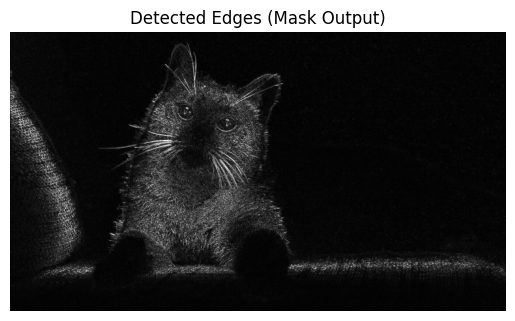

In [52]:
# Step 5: Visualize
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("output.bmp").convert("L")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Detected Edges (Mask Output)")
plt.show()


In [ ]:
from google.colab import files
files.download("output.bmp")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
printf("--- Object Detection Output Matrix (%d x %d) ---\n", height, width);
for (int y = 0; y < height; y++) {
    for (int x = 0; x < width; x++) {
        printf("%3d ", result[y * width + x]);
    }
    printf("\n");
}

In [ ]:
!ls -lh output.bmp